#  The Mythical Pegasus: Deep Learning Summative Assignment

## Google Drive Integration

Mount Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

Import modules.

In [2]:
import math
import numpy as np
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10
import random
from math import ceil

Set random seed for reproducibility

In [3]:
seed = 742
random.seed(seed)
torch.manual_seed(seed)
print('random seed: ', seed)

random seed:  742


Set device.

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: ', device)

device:  cuda


## Data loading

Fetch CIFAR-10 training data.

In [5]:
train_data = torchvision.datasets.CIFAR10(
    'drive/My Drive/GitHub/dcgan-pegasus/cifar10', train=True, download=True, 
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.Resize(32),
                                              torchvision.transforms.ToTensor(),
                                              ])
    )

Files already downloaded and verified


List class names in the training data.

In [6]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Create train data loader.

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, 
                                               batch_size=64, drop_last=True)

## Data preview

Define function to plot images from a data loader.

In [8]:
def plot_images(dataloader, n_imgs=25, show_colour=True):
  print(f'> Size of training dataset {len(dataloader.dataset)}')
  plt.figure(figsize=(10,10))
  for i in range(n_imgs):
    n_rows = ceil(n_imgs**0.5)
    n_cols = ceil(n_imgs/n_rows) 
    plt.subplot(n_rows, n_cols, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if show_colour:
      plt.imshow(dataloader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    else: # greyscale 
      plt.imshow(dataloader.dataset[i][0][0], cmap=plt.cm.binary)
    plt.xlabel(class_names[dataloader.dataset[i][1]])

Plot images from the training data loader.

> Size of training dataset 50000


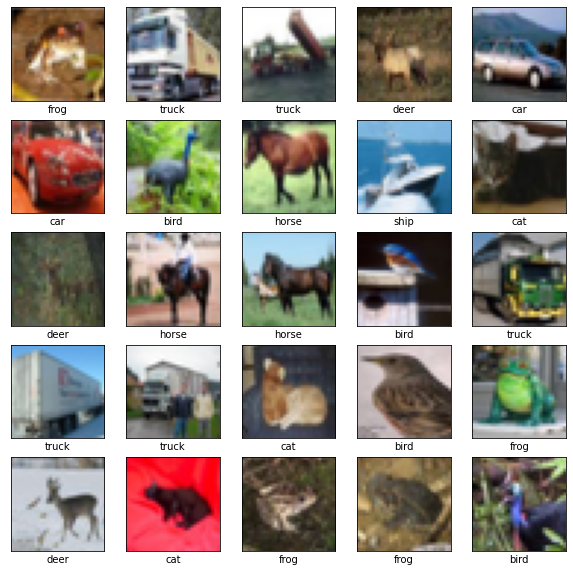

In [9]:
plot_images(train_dataloader)

## Data pre-processing

### Create subsets by label.

Define functions to help get subset of the original data with a specific label or labels (e.g. 'horse' and/or 'bird').

In [10]:
def get_data_of_class(labels, data):
  target = [class_names.index(class_name) for class_name in labels]
  new_data_indices = [i for i in range(len(data)) if data[i][1] in target]
  new_data = torch.utils.data.Subset(data, new_data_indices)
  return new_data

def make_loader(data):
  return torch.utils.data.DataLoader(data, shuffle=True, batch_size=64, 
      drop_last=True)

Create subsets.

In [11]:
bird_data = get_data_of_class(['bird'], train_data)
horse_data = get_data_of_class(['horse'], train_data)
bird_and_horse_data = get_data_of_class(['bird', 'horse'], train_data)

Create loaders.

In [12]:
bird_loader = make_loader(bird_data)
horse_loader = make_loader(horse_data)
bird_and_horse_loader = make_loader(bird_and_horse_data)

View data from each subset.

> Size of training dataset 5000


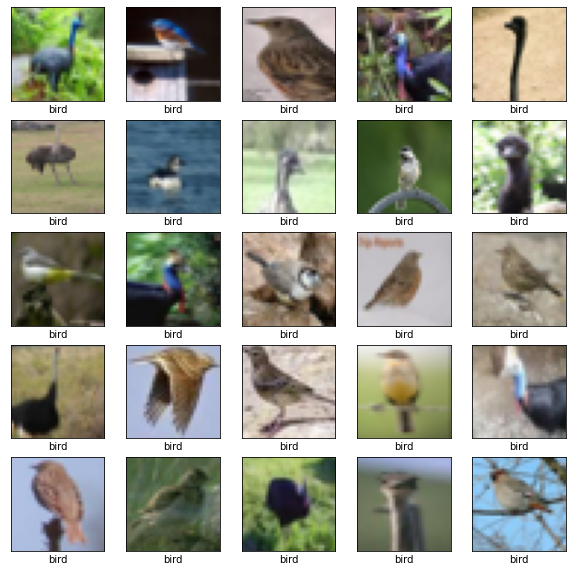

In [13]:
plot_images(bird_loader)

> Size of training dataset 5000


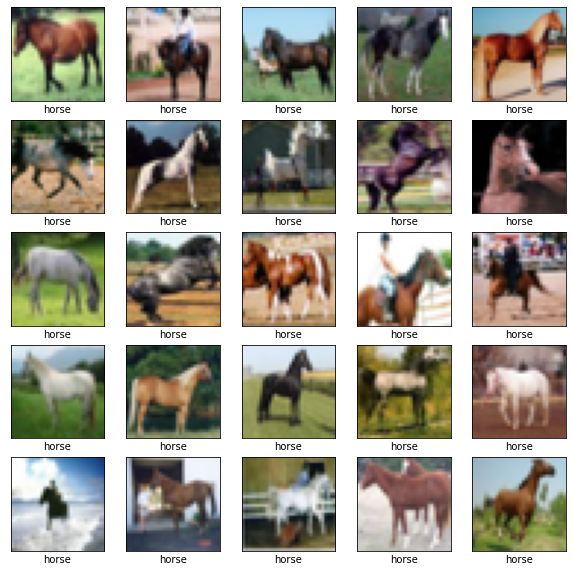

In [14]:
plot_images(horse_loader)

> Size of training dataset 10000


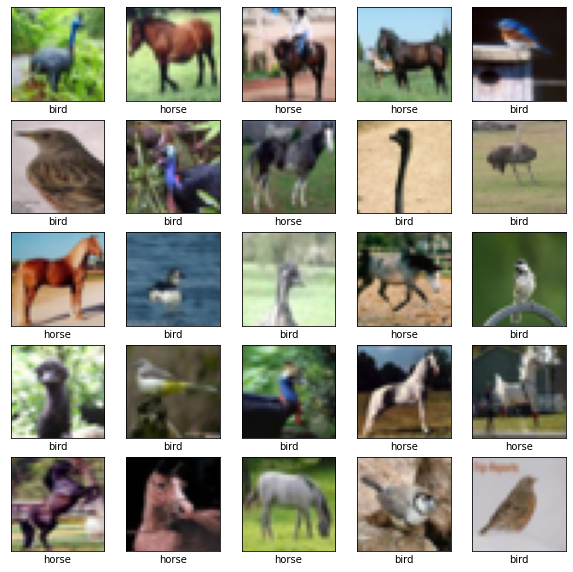

In [15]:
plot_images(bird_and_horse_loader)

### Create subsets by a classifier.

Pegasi are typically depicted with outspread wings, so we want to identify the pictures of birds also with outspread wings. 

#### Data loading

Fetch CIFAR-10 test data.

In [16]:
test_data = torchvision.datasets.CIFAR10(
    'drive/My Drive/GitHub/dcgan-pegasus/cifar10', train=False, download=True, 
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.Resize(32),
                                              torchvision.transforms.ToTensor(),
                                              ])
    )

Files already downloaded and verified


Create test data loader.

In [17]:
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, 
                                               batch_size=64, drop_last=True)

Define helper function to make getting another batch of data easier.

In [18]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

Create train and test data iterators.

In [19]:
train_iterator = iter(cycle(train_dataloader))
test_iterator = iter(cycle(test_loader))

#### Data preview

View the test data.

> Size of training dataset 10000


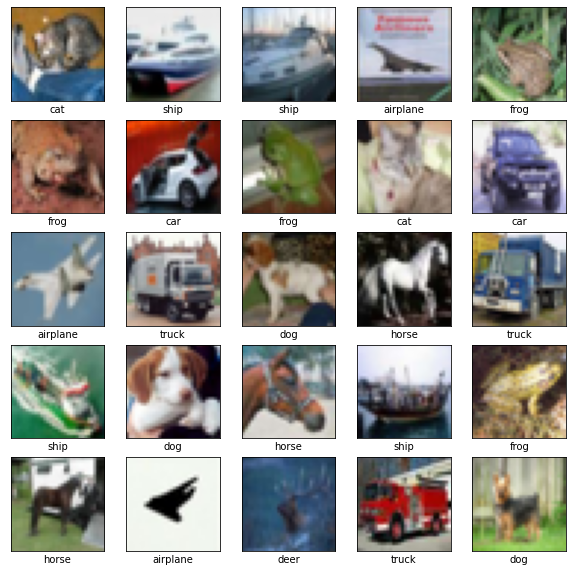

In [20]:
plot_images(test_loader)

#### Model definition (ConvNet)

Define a convolutional network class.

In [21]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(128, 10, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.AvgPool2d((4,4)))
        self.layers = layers

    def forward(self, x):
        for m in self.layers:
            x = m(x)
        return x

#### Model training

Create the network.

In [22]:
N = ConvolutionalNetwork().to(device)

View the number of network parameters 

In [23]:
print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

> Number of network parameters 155008


Initialise the optimiser.

In [24]:
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)

Train and test.

In [ ]:
num_epochs = 10
epoch = 0
while (epoch<num_epochs):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x).view(x.size(0), len(class_names))
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # iterate entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x).view(x.size(0), len(class_names))
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    print('train loss: {:.3f}, train acc: {:.3f}, test acc: {:.3f}'.format(
        train_loss_arr.mean(),train_acc_arr.mean(),test_acc_arr.mean()))

    epoch = epoch+1

#### Model saving/loading

Save the trained classifier.

In [ ]:
PATH = './drive/My Drive/GitHub/dcgan-pegasus/classifier_save.pth'
torch.save(N.state_dict(), PATH)

Load the trained classifier.

In [25]:
PATH = './drive/My Drive/GitHub/dcgan-pegasus/classifier_save.pth'
N = ConvolutionalNetwork().to(device)
N.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Results

Define functions to help with dataset inference.

In [26]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

def plot_classifier_images(test_images, test_labels, test_preds):
  num_rows = 8
  num_cols = 8
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, test_preds, test_labels.cpu(), test_images.cpu().squeeze().permute(1,3,2,0).contiguous().permute(3,2,1,0))
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, test_preds, test_labels)

View classifier results.

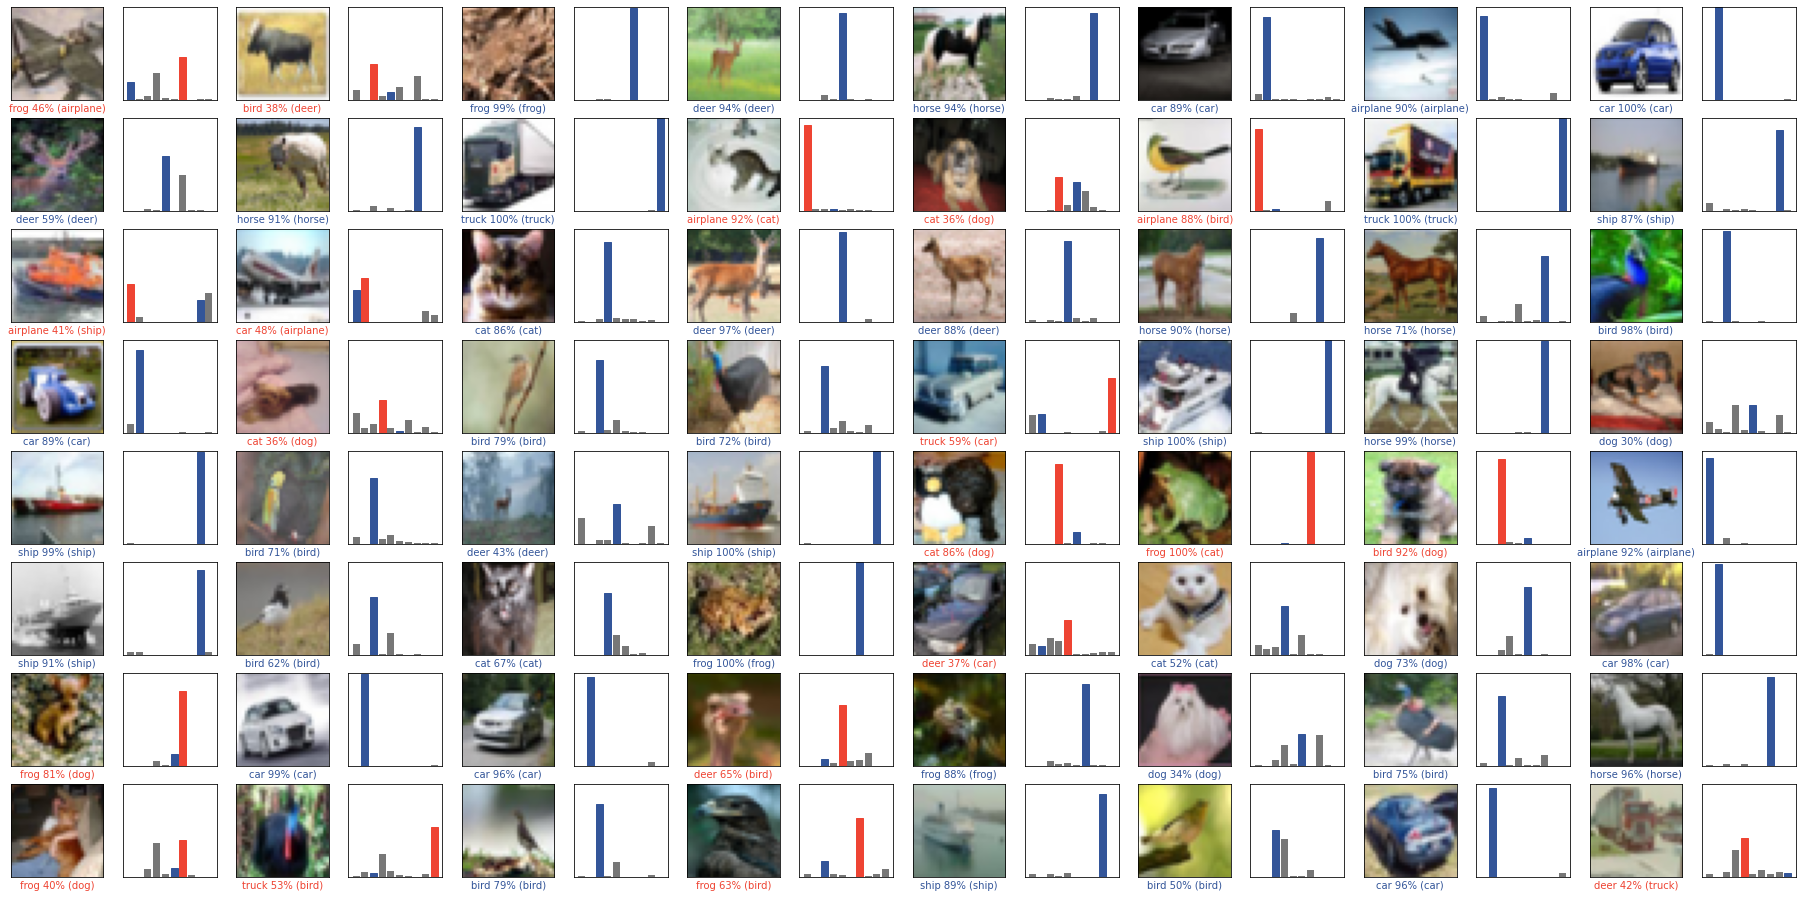

In [27]:
test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images).view(test_images.size(0), len(class_names)), dim=1).data.squeeze().cpu().numpy()
plot_classifier_images(test_images, test_labels, test_preds)

#### Feature isolation

Create iterator for bird data.

In [28]:
bird_iterator = iter(cycle(bird_loader))

View results where a bird has been misclassified as a plane (in an attempt to isolate the 'wing' feature).

selected_images shape: torch.Size([64, 3, 32, 32])


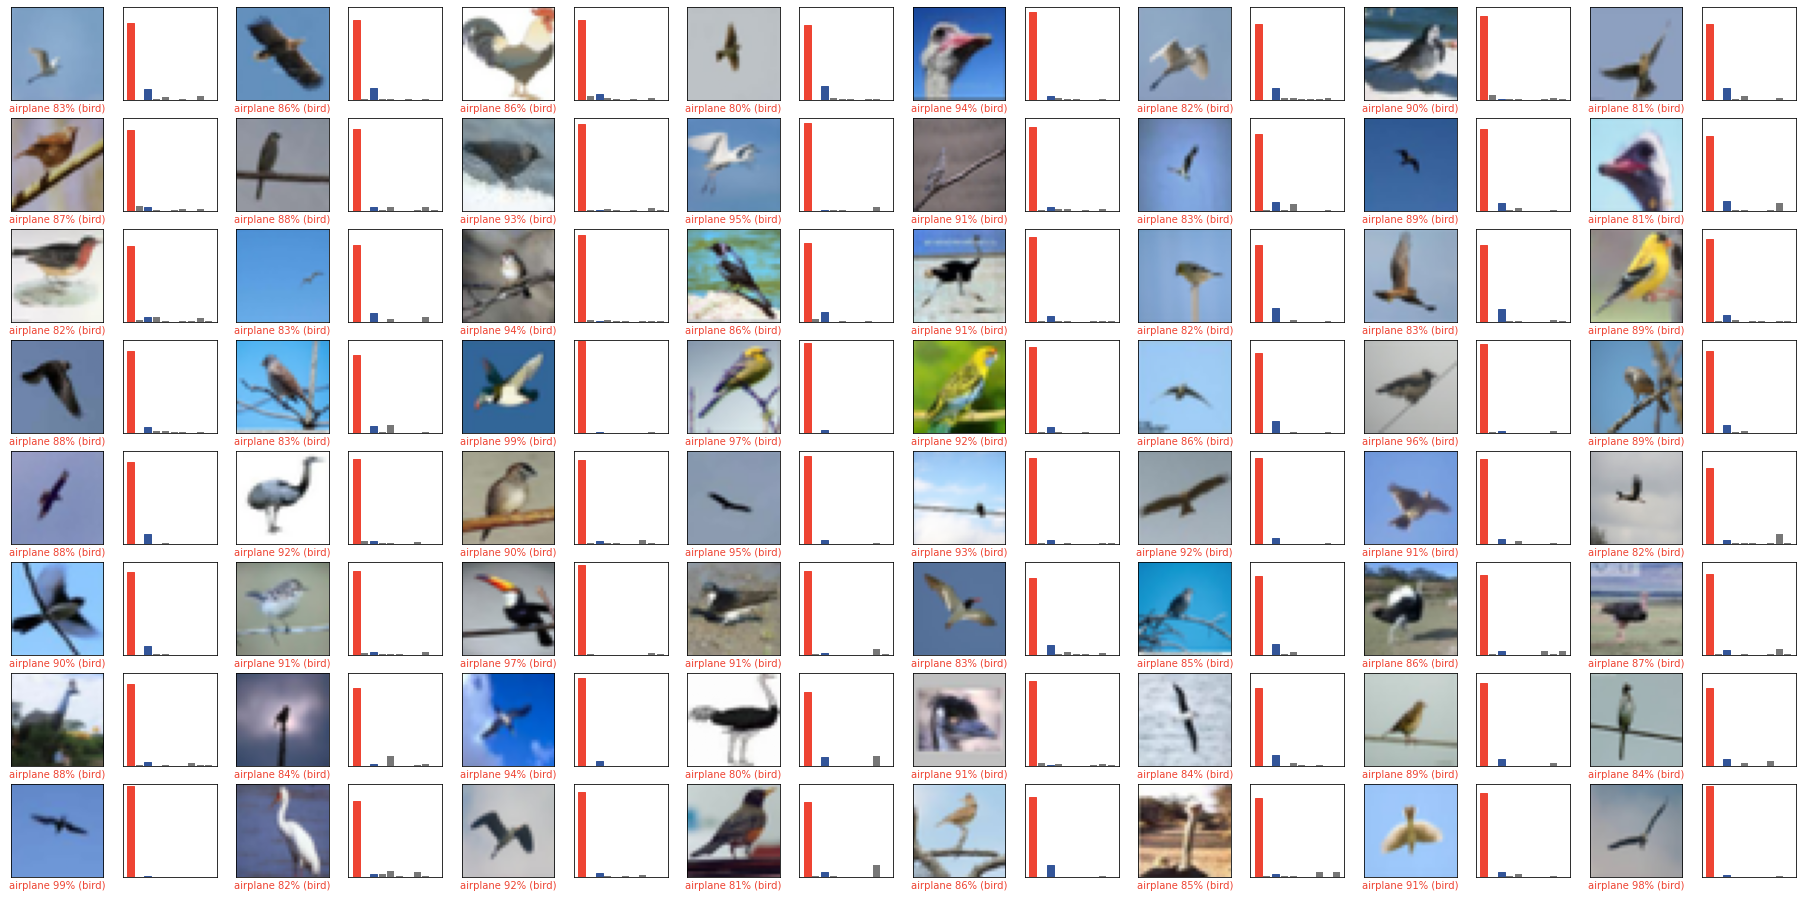

In [29]:
count = 0
while count < 64:
  test_images, test_labels = next(bird_iterator)
  test_images, test_labels = test_images.to(device), test_labels.to(device)
  test_preds = torch.softmax(N(test_images).view(test_images.size(0), len(class_names)), dim=1).data.squeeze().cpu().numpy()
  for i in range(64):
    if count >= 64:
      break
    
    j = np.argmax(test_preds[i])
    if j == 0 and np.max(test_preds[i]) > 0.8:
      if count == 0:
        selected_images = test_images[i].unsqueeze(0)
        selected_labels = test_labels[i].unsqueeze(0)
        selected_preds = np.array([test_preds[i]])
        count += 1
      else:
        selected_images = torch.cat([selected_images, test_images[i].unsqueeze(0)])
        selected_labels = torch.cat([selected_labels, test_labels[i].unsqueeze(0)])
        selected_preds = np.append(selected_preds, [test_preds[i]], axis=0)
        count += 1

print("selected_images shape:", selected_images.shape)
test_images = selected_images
test_labels = selected_labels
test_preds = selected_preds

plot_classifier_images(test_images, test_labels, test_preds)

View results where a horse has been correctly classified with high probability (in an attempt to only get side-views of the horse).

In [35]:
horse_train_iterator = iter(cycle(horse_loader))
chosen_data = []

In [39]:
for i in range(10):
  count = 0
  while count < 64:
    test_images, test_labels = next(horse_train_iterator)
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_preds = torch.softmax(N(test_images).view(test_images.size(0), len(class_names)), dim=1).data.squeeze().cpu().numpy()
    for i in range(64):
      if count >= 64:
        break
      
      j = np.argmax(test_preds[i])
      if j == test_labels[i] and np.max(test_preds[i]) > 0.8:
        if count == 0:
          selected_images = test_images[i].unsqueeze(0)
          selected_labels = test_labels[i].unsqueeze(0)
          selected_preds = np.array([test_preds[i]])
          count += 1
        else:
          selected_images = torch.cat([selected_images, test_images[i].unsqueeze(0)])
          selected_labels = torch.cat([selected_labels, test_labels[i].unsqueeze(0)])
          selected_preds = np.append(selected_preds, [test_preds[i]], axis=0)
          count += 1

  print("selected_images shape:", selected_images.shape)
  test_images = selected_images
  test_labels = selected_labels
  test_preds = selected_preds
  chosen_data.append(selected_images)

  plot_classifier_images(test_images, test_labels, test_preds)

Output hidden; open in https://colab.research.google.com to view.

In [56]:
len(chosen_data)
for i, data in enumerate(chosen_data, start=0):
  print(i, data.shape)
  break

0 torch.Size([64, 3, 32, 32])


## Model definition (DCGAN)

Set hyperparameters.

In [41]:
nz = 100
nf = 32
nc = 3

### Define function to initialise weights.

In [42]:
def weights_init(m):
  """initialises custom weights (for the generator and discriminator networks)"""
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

### Define the generator.

Define the generator class.

In [43]:
class Generator(nn.Module):
  """A generator that generates fake images.
  
  Maps the latent space vector (z) to a RGB image with the same size as the 
  training images (i.e. 3x32x32). 
  """
  def __init__(self, nz=nz, nf=nf, nc=nc):
    """Inits Generator network.

    The network is a series of strided two dimensional convolutional transpose 
    layers, each paired with a 2d batch norm layer and a relu activation. The 
    output of the generator is fed through a tanh function to return it to 
    the input data range of [−1,1].

    Args:
      nz (int): Size of latent space vector (z). 
      nf (int): Size of feature maps.
      nc (int): Number of channels in the training images.
    """
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, nf * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(nf * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(nf * 2, nf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf),
        nn.ReLU(True),
        nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, input):
    """  
    
    After the first layer, the state size is:  (nf*4) x 4 x 4.
    After the second layer, the state size is: (nf*2) x 8 x 8.
    After the third layer, the state size is:  (nf) x 16 x 16.
    After the fourth layer, the state size is: (nc) x 32 x 32.
    """
    return self.main(input)

Print the generator model.

In [44]:
netG = Generator().to(device)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Inspect generator output.

torch.Size([64, 3, 32, 32])
(3, 32, 32)


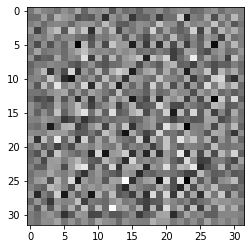

In [45]:
netG.apply(weights_init)

for i, data in enumerate(horse_loader, start=0):
  if i > 0:
      break
  print(data[i].shape)
  real_cpu = data[0].to(device)
  batch_size = data[0].size(0)
  # Generate batch of latent vectors
  noise = torch.randn(batch_size, 100, 1, 1, device=device)
  # Generate fake image batch with G
  fake = netG(noise)

img = fake[0].cpu()
img = img.detach().numpy()

print(img.shape)
plt.imshow(img[0], cmap=plt.cm.binary)

### Define the discriminator.

Define the discriminator class.

In [46]:
class Discriminator(nn.Module):
  """A discriminator that classifies an image as fake or not.

  The discriminator is a binary classification network that takes a 3x32x32 
  image as input and outputs a scalr probability that the input image is 
  real.
  """ 
  def __init__(self, nc=nc, nf=nf):
    """Inits Discriminator network.
    
    The network is a series of Conv2d, BatchNorm2d, and LeakyReLU layers. The 
    output of the discriminator is fed through a Sigmoid activation function to
    obtain the final probability.

    Note:
      The DCGAN paper mentions it is a good practice to use strided convolution 
      rather than pooling to downsample because it lets the network learn its 
      own pooling function.

    Args:
      nc (int): Number of channels in the training images.
      nf (int): Size of feature maps.
    """
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(nf * 4, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
      )

  def forward(self, input):
    """Passes input through network.

    After the first layer, the state size is:  (nf) x 16 x 16
    After the second layer, the state size is: (nf*2) x 8 x 8.
    After the third layer, the state size is:  (nf*4) x 4 x 4.
    After the fourth layer, the state size is: 1

    Args:
      input: (nc) x 32 x 32
    """
    return self.main(input)

Print the discriminator model.

In [47]:
netD = Discriminator().to(device)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


## (Experimenting)

> Size of training dataset 1


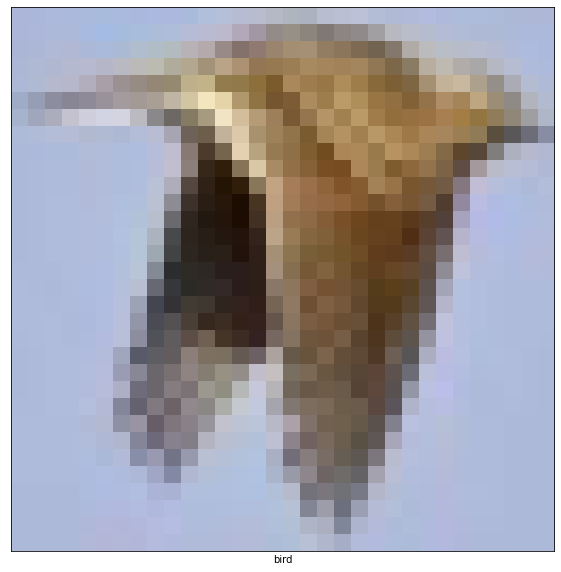

In [ ]:
handpicked_data = torch.utils.data.Subset(bird_and_horse_data, [29]) # [22, 29, 34, 39, 48, 96]
handpicked_loader = torch.utils.data.DataLoader(handpicked_data, shuffle=True, batch_size=batch_size)
plot_loader(handpicked_loader, 1)

In [ ]:
len(handpicked_data[0])
handpicked_data[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
for i, data in enumerate(handpicked_loader, start=0):
  if i > 0:
      break
  print(data[0].shape)

torch.Size([4, 3, 32, 32])


In [ ]:
x = torch.zeros(1, 2, 3)
x

tensor([[[0., 0., 0.],
         [0., 0., 0.]]])

In [ ]:
torch.tensor([[1, 2, 3]]).shape

torch.Size([1, 3])

In [ ]:
x = torch.zeros(1, 3, 32, 32)
x = x.repeat(4,1,1, 1)
# print(x)
print(x.shape)

torch.Size([4, 3, 32, 32])


In [ ]:
print(bird_loader.dataset[16][0].shape)

data = bird_loader.dataset[16][0]
data = data.repeat(64)

print(data.shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [ ]:
for i, data in enumerate(horse_loader, start=0):
  if i > 0:
      break

  print(data[0].shape)

torch.Size([64, 3, 32, 32])


## Model Training

Set hyperparameters.

In [65]:
num_epochs = 250
lr = 0.0002
beta1 = 0.5

dataloader = horse_loader

Create the generator and discriminator.

In [49]:
netG = Generator().to(device)
netD = Discriminator().to(device)

Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.

In [50]:
netG.apply(weights_init)
netD.apply(weights_init)
print('')

Initialize BCE Loss function

In [51]:
criterion = nn.BCELoss()

Create batch of latent vectors that we will use to visualize the progression of the generator

In [52]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

Establish convention for real and fake labels during training

In [53]:
real_label = 1
fake_label = 0

Setup Adam optimizers for both G and D

In [54]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Main training loop

In [66]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    # if fine_tune == True and epoch > limit:
    #     dataloader = handpicked_loader
    
    for i, data in enumerate(chosen_data, start=0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)

        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("Training stopped")

Starting Training Loop...
[0/250][0/78]	Loss_D: 0.4069	Loss_G: 1.5227	D(x): 0.7514	D(G(z)): 0.1017 / 0.2442
[1/250][0/78]	Loss_D: 0.3816	Loss_G: 2.0553	D(x): 0.8085	D(G(z)): 0.1423 / 0.1567
[2/250][0/78]	Loss_D: 0.4035	Loss_G: 1.8317	D(x): 0.7521	D(G(z)): 0.1000 / 0.1842
[3/250][0/78]	Loss_D: 0.3577	Loss_G: 2.3622	D(x): 0.8322	D(G(z)): 0.1481 / 0.1144
[4/250][0/78]	Loss_D: 0.3692	Loss_G: 2.0128	D(x): 0.7913	D(G(z)): 0.1171 / 0.1523
[5/250][0/78]	Loss_D: 0.5060	Loss_G: 1.4188	D(x): 0.6548	D(G(z)): 0.0646 / 0.2836
[6/250][0/78]	Loss_D: 0.3238	Loss_G: 2.3280	D(x): 0.8778	D(G(z)): 0.1678 / 0.1115
[7/250][0/78]	Loss_D: 0.3535	Loss_G: 2.3519	D(x): 0.8477	D(G(z)): 0.1603 / 0.1139
[8/250][0/78]	Loss_D: 0.4339	Loss_G: 1.6826	D(x): 0.7488	D(G(z)): 0.1220 / 0.2074
[9/250][0/78]	Loss_D: 0.3725	Loss_G: 1.9434	D(x): 0.7931	D(G(z)): 0.1217 / 0.1650
[10/250][0/78]	Loss_D: 0.3306	Loss_G: 2.3388	D(x): 0.8477	D(G(z)): 0.1439 / 0.1233
[11/250][0/78]	Loss_D: 1.1880	Loss_G: 1.5666	D(x): 0.5469	D(G(z)): 0.28

## Model saving/laoding

Save the trained generator.

In [69]:
PATH = './drive/My Drive/GitHub/dcgan-pegasus/horse_generator_save.pth'
torch.save(netG.state_dict(), PATH)

Save the trained discriminator.

In [70]:
PATH = './drive/My Drive/GitHub/dcgan-pegasus/horse_discriminator_save.pth'
torch.save(netD.state_dict(), PATH)

Load the trained generator and discriminator. 

In [71]:
PATH = './drive/My Drive/GitHub/dcgan-pegasus/horse_generator_save.pth'
netG2 = Generator().to(device)
netG2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Results

In [67]:
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

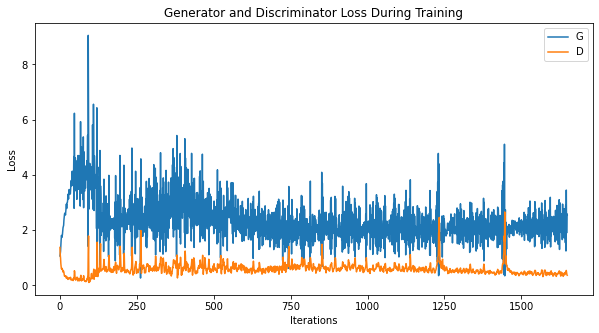

In [61]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

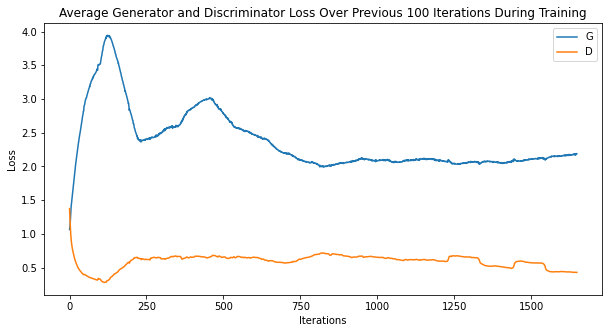

In [62]:
def get_running_avg(losses):
  running_avg = np.zeros(len(losses))
  for i in range(len(running_avg)):
      running_avg[i] = np.mean(losses[max(0, i-100):(i+1)])
  return running_avg

running_avg_G_losses = get_running_avg(G_losses)
running_avg_D_losses = get_running_avg(D_losses)

plt.figure(figsize=(10,5))
plt.title("Average Generator and Discriminator Loss Over Previous 100 Iterations During Training")
plt.plot(running_avg_G_losses,label="G")
plt.plot(running_avg_D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

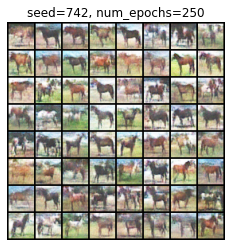

In [68]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
# plt.subplot(1,2,2)
plt.axis("off")
plt.title("seed={}, num_epochs={}".format(seed, num_epochs))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()